<!--
---
title: "Random forest regression. K nearest neighbor regression"
author: "Madhura Killedar, Darya Vanichkina"

keypoints: 
- Random forests can be combined to solve regression tasks
- kNN is a method that can also be used for regression
objectives:
- To fit a RF and KNN model to our data
- To explore the effect of hyperparameters on model fit
questions:
- How do we implement tree-based and proximity-based methods in python?
source: Rmd
teaching: 45
exercises: 45
bibliography: references.bib
---
-->


## Random forest regression. K nearest neighbor regression

In [13]:
websiterendering = True
# when delivering live coding, these libraries and code in this cell have already been loaded
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import statsmodels.api as sm
import seaborn as sns
import pickle

import sys
sys.path.insert(0, 'py-earth')
from pyearth import Earth

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.utils import resample


# Set up plotting options for seaborn and matplotlib
sns.set_context('notebook') 
sns.set_style('ticks') 
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

# load from previous lessons
cached_files = ['models/ames_train_y.pickle','models/ames_test_y.pickle',
                'models/ames_train_X.pickle','models/ames_test_X.pickle',
                'models/predictors.pickle','models/ames_ols_all.pickle',
                'models/ames_ridge.pickle','models/ames_lasso.pickle', 
                'models/ames_enet.pickle','models/ames_mars.pickle',
               'models/ames_pcr.pickle', 'models/ames_plsr.pickle']

for file in cached_files:
    with open(file, 'rb') as f:
        objectname = file.replace('models/', '').replace('.pickle', '')
        exec(objectname + " = pickle.load(f)")
        f.close()

## 
def assess_model_fit(listOfModels,
                     listOfMethodNamesAsStrings, 
                     datasetX, 
                     datasetY):
    columns= ['RMSE', 'R2', 'MAE']
    rows=listOfMethodNamesAsStrings
    results=pd.DataFrame(0.0, columns=columns, index=rows)
    for i, method in enumerate(listOfModels):
        tmp_dataset_X=datasetX
        # while we build the model and predict on the log10Transformed sale price, we display the error in dollars
        # as that makes more sense
        y_pred=10**(method.predict(tmp_dataset_X))
        results.iloc[i,0] = np.sqrt(mean_squared_error(10**(datasetY), y_pred))
        results.iloc[i,1] = r2_score(10**(datasetY), y_pred)
        results.iloc[i,2] = mean_absolute_error(10**(datasetY), y_pred)
    return(results.round(3))

In [14]:
list(np.arange(3,11,1))

[3, 4, 5, 6, 7, 8, 9, 10]

## Random Forest
In random forest, each tree in the ensemble is built from a bootstrap sample from the training set. In addition, when splitting a node during the construction of the tree, the split that is chosen is the best split among a random subset of the features.

In [15]:
# tuning grid was defined to optimise the following RF parameters:
param_grid = {"n_estimators": list(np.arange(10,160,10)),
            'max_depth': list(np.arange(3,11,1)),
            'min_samples_split': [0.005, 0.01, 0.02],
             'max_features': ['sqrt', 'auto']}

This was optimised on the HPC (we'll see some sample scripts for this in the next session), and the best outcome of this ended up being:

```
{'max_depth': 9, 'min_samples_split': 0.005, 
'max_features': 'auto', 'n_estimators': 150}

# best score
0.8735794018428228
```


In [16]:
from sklearn.ensemble import RandomForestRegressor

ames_RF = Pipeline([
    ('estimator', RandomForestRegressor(n_estimators=150, 
                                       max_depth = 9,
                                       min_samples_split = 0.005,
                                       max_features = 'auto'))
    #('estimator', GridSearchCV(RandomForestRegressor(), param_grid, scoring='r2', cv=10))
])

if websiterendering:
    with open('models/ames_RF.pickle', 'rb') as f:
        ames_RF = pickle.load(f)
else:
    # STUDENTS: execute the line of code below
    ames_RF.fit(ames_train_X, ames_train_y)
    pickle.dump(ames_RF, open('models/ames_RF.pickle', 'wb'))
    
#best_RF = ames_RF.named_steps.estimator.best_estimator_
#print(best_RF)

In [17]:
ames_RF.named_steps['estimator']

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=0.005,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

> ## Challenge 1
>
> 1. Try different hyperparameters, how does it impact the feature importances and RMSE (see below)?
> 
> {: .source}
>
{: .challenge}

In [18]:
def plot_coefficients(model, labels):
    importance = model.feature_importances_

    table = pd.Series(importance.ravel(), index = labels).sort_values(ascending=True, inplace=False)
    
    reference = pd.Series(np.abs(importance.ravel()), index = labels).sort_values(ascending=False, inplace=False)
    reference = reference.iloc[:20]
    table = table[reference.index]
    table = table.sort_values(ascending=True, inplace=False)

    fig, ax = fig, ax = plt.subplots()
    table.T.plot(kind='barh', edgecolor='black', width=0.7, linewidth=.8, alpha=0.9, ax=ax)
    ax.tick_params(axis=u'y', length=0) 
    ax.set_title('Feature Importances (twenty largest in absolute value)', fontsize=14)
    sns.despine()
    return fig, ax

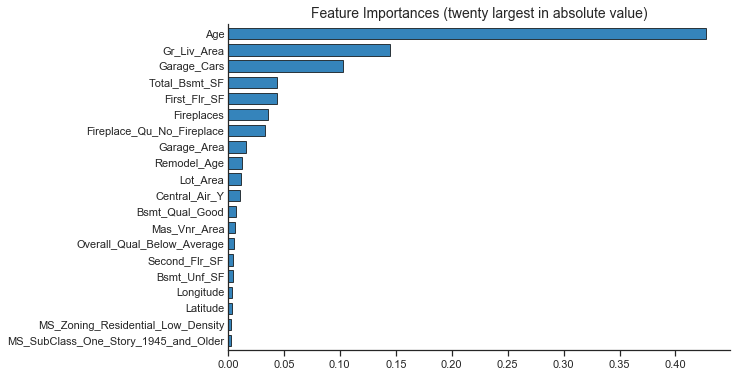

In [19]:
plot_coefficients(ames_RF.named_steps['estimator'], predictors)
plt.show()

## k-Nearest Neighbours Regression

In [20]:
# tuning grid will be defined to optimise the following knn parameters:
param_grid = {"n_neighbors": list(np.arange(3,21,2)),
              "weights": ['uniform','distance'],
             }

# print(ames_kNN.named_steps['estimator'].best_score_)
#0.7842456772785913
# KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',metric_params=None, n_jobs=1, n_neighbors=7, p=2, weights='distance')


In [21]:
from sklearn.neighbors import KNeighborsRegressor

# Next, let's try to tune locally, trying 6, 7 and 8 neighbors:
param_grid = {"n_neighbors": [6,7,8],
              "weights": ['uniform']}


ames_kNN = Pipeline([
    ('scaler', StandardScaler()),
    #('scaler', RobustScaler()),
    #('estimator', KNeighborsRegressor(n_neighbors=10))
    ('estimator', GridSearchCV(KNeighborsRegressor(), param_grid, scoring='r2', cv=10))
])


if websiterendering:
    with open('models/ames_knn.pickle', 'rb') as f:
        ames_kNN = pickle.load(f)
else:
    # STUDENTS: RUN THE LINE BELOW ONLY:
    ames_kNN.fit(ames_train_X, ames_train_y)
    pickle.dump(ames_kNN, open('models/ames_knn.pickle', 'wb'))

    
    
print(ames_kNN.named_steps['estimator'].best_estimator_)
print(ames_kNN.named_steps['estimator'].best_score_)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=8, p=2,
                    weights='uniform')
0.777542140008902


## Compare Models

In [22]:
# What was the RMSE on the training data?
assess_model_fit(listOfModels=[ames_ols_all, ames_ridge, ames_lasso, ames_enet, ames_pcr, ames_plsr,ames_mars, ames_RF, ames_kNN],
                listOfMethodNamesAsStrings=['OLS','Ridge', 'Lasso', 'ENet','PCR','PLSR', 'MARS','RF', 'kNN'],
                datasetX=ames_train_X,
                datasetY=ames_train_y).sort_values("RMSE")

,RMSE,R2,MAE
OLS,15757.714,0.961,10931.668
RF,16038.217,0.959,10884.483
Lasso,16480.809,0.957,11448.829
Ridge,16497.181,0.957,11462.724
PLSR,16524.567,0.957,11602.496
PCR,16752.591,0.955,11765.495
ENet,17041.271,0.954,11799.798
MARS,19172.923,0.942,13498.476
kNN,31651.974,0.841,20155.938


In [23]:
# What was the RMSE on the testing data?
assess_model_fit(listOfModels=[ames_ols_all, ames_ridge, ames_lasso, ames_enet, ames_pcr, ames_plsr, ames_mars, ames_RF, ames_kNN],
                listOfMethodNamesAsStrings=['OLS','Ridge', 'Lasso', 'ENet','PCR','PLSR','MARS', 'RF', 'kNN'],
                datasetX=ames_test_X,
                datasetY=ames_test_y).sort_values("RMSE")

,RMSE,R2,MAE
ENet,19801.125,0.933,13317.465
Lasso,19864.493,0.933,13120.146
Ridge,20024.975,0.932,13270.709
PLSR,20113.237,0.931,13372.746
OLS,20541.485,0.928,13346.733
PCR,20988.955,0.925,13957.143
MARS,23226.020,0.908,15355.804
RF,27382.699,0.872,16858.700
kNN,34498.941,0.797,22983.686
